In [1]:
import pandas as pd
import pickle5 as pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from nltk.probability import FreqDist
from pprint import pprint
from statsmodels.nonparametric.smoothers_lowess import lowess
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from nltk.tokenize import word_tokenize
import re
# _root_path = '/content/drive/MyDrive/PoliticalSentimentAnalysis/'
_root_path = '../'

# load data
with open(_root_path + 'data/tweets.pkl', 'rb') as f:
    tweets_df = pickle.load(f)

# Get all tweets from 2019
tweets_df.sort_values(by='Date', inplace=True)
tweets_df = tweets_df[tweets_df.Date > datetime.datetime(2019,1,1)]

emotions = ['Anger', 'Anticipation', 'Joy', 'Trust', 'Fear','Surprise', 'Sadness', 'Disgust']

# Rename party for clearer plots and set party color
tweets_df.Party = tweets_df.Party.apply(lambda p: 'Republican' if p == 'R' else 'Democratic')
party_colors = dict(
    D='tab:blue',
    Democratic='tab:blue',
    R='tab:red',
    Republican='tab:red',
    All='tab:gray'
)

# set default params
plt.rcParams["figure.figsize"] = (8, 5)
plt.rc('font', size=12)

In [2]:
# some preprocessing
non_characters = re.compile(r"[^A-Za-z\s]+")
dataset = list(tweets_df.text.apply(lambda t: word_tokenize(non_characters.sub('', t))))
# create tfidf model
dct = Dictionary(dataset)
dct.filter_extremes(no_below=100)
corpus = [dct.doc2bow(line) for line in dataset]  # convert corpus to BoW format
tfidf = TfidfModel(corpus)  # fit model

In [4]:
high_tfidf_words = []
fdist = []
print('Words with highest TF-IDF values')

for party in ['Democratic', 'Republican']:
    # iterates party-wise over all docs in corpus
    high_tfidf_words_party = []
    for bow in np.array(corpus)[list(tweets_df.reset_index()[(tweets_df.Party == party).values].index)]:
        # get word with max tfidf score
        if len(bow) == 0:
            continue
        high_tfidf_words_party.append(bow[np.array(tfidf[bow]).argmax(axis=0)[1]][0])

    high_tfidf_words.append([dct[id] for id in high_tfidf_words_party])

    # get frequency list
    fdist.append(FreqDist(high_tfidf_words[-1]))
    print(f'\n{party}')
    pprint(fdist[-1].most_common(10))

Words with highest TF-IDF values

Democratic
[('Census', 1382),
 ('gun', 948),
 ('her', 888),
 ('climate', 708),
 ('testing', 706),
 ('vaccine', 672),
 ('his', 662),
 ('food', 631),
 ('veterans', 623),
 ('Black', 521)]

Republican
[('border', 905),
 ('China', 576),
 ('energy', 554),
 ('vaccine', 466),
 ('her', 376),
 ('his', 375),
 ('USMCA', 352),
 ('veterans', 323),
 ('Capitol', 292),
 ('impeachment', 281)]


<ipython-input-4-289695eb968a>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for bow in np.array(corpus)[list(tweets_df.reset_index()[(tweets_df.Party == party).values].index)]:


In [48]:
print('Most common hashtags')

hashtags = []
fdist = []
for i, df in tweets_df.groupby('Party'):
    hashtags.append([h
                for l in df.hashtags.values
                for h in l])
    fdist.append(FreqDist(hashtags[-1]))
    print(f'\n{i}')
    pprint(fdist[-1].most_common(10))



Democratic
[('COVID19', 20403),
 ('ForThePeople', 5566),
 ('AmericanRescuePlan', 3726),
 ('coronavirus', 3076),
 ('2020Census', 3014),
 ('HeroesAct', 2825),
 ('AZ01', 2491),
 ('ProtectOurCare', 1818),
 ('BlackHistoryMonth', 1617),
 ('EndGunViolence', 1563),
 ('COVID', 1467),
 ('VA07', 1431),
 ('GetCovered', 1412),
 ('HR8', 1323),
 ('SOTU', 1288),
 ('EqualityAct', 1282),
 ('HR1', 1255),
 ('JusticeInPolicing', 1201),
 ('CARESAct', 1171),
 ('TrumpShutdown', 1131)]

Republican
[('COVID19', 7158),
 ('coronavirus', 2917),
 ('USMCA', 2347),
 ('SOTU', 1688),
 ('PPP', 1344),
 ('China', 1223),
 ('COVID', 1199),
 ('PaycheckProtectionProgram', 1146),
 ('MI06', 1049),
 ('CCP', 889),
 ('ICYMI', 819),
 ('utpol', 736),
 ('NY21', 677),
 ('AR3', 654),
 ('InItTogether', 631),
 ('Coronavirus', 627),
 ('AL03', 615),
 ('BidenBorderCrisis', 579),
 ('Ohio', 555),
 ('SCOTUS', 552)]


In [2]:
topic_hashtags = {
    'All': False,

    'COVID19': ['covid', 'coronavirus'],
    'Acts': ['hr', 'act', 'program'],
    'Capitol riots': ['capitol riot'],

    'Guns': ['gun'],
    'Climate': ['climate'],
    'Health Care': ['health care', 'obamacare', 'protectourcare', 'getcovered', 'aca'],

    'Border': ['border'],
    'China': ['china'],
    'USMCA': ['usmca']
    }

all_topics = pd.DataFrame()
emotions = ['Anger', 'Anticipation', 'Joy', 'Trust', 'Fear','Surprise', 'Sadness', 'Disgust', 'Polarity']

for topic, hashtags in topic_hashtags.items():
    if hashtags:
        df = tweets_df[tweets_df.text.apply(lambda l: any(h in l.lower() for h in hashtags)) +
                       tweets_df.hashtags.apply(lambda l: any(h in str(l).lower() for h in hashtags))
                      ][['Date', 'Party'] + emotions]
    else:
        df = tweets_df[['Date', 'Party'] + emotions]
    df.set_index('Date', inplace=True)
    df = df.groupby(['Party', pd.Grouper(freq='W')]).mean()
    df = df.stack().reset_index()
    df.columns = ['Party', 'Date', 'Emotion', 'Average Share']

    # LOWESS Smoothing
    df = df.sort_values(['Party', 'Emotion', 'Date'])
    smoothing = list()
    for i, group in df.groupby(['Party', 'Emotion']):
        smoothing.extend(lowess(group['Average Share'].values, group.Date.values, frac=1/3, return_sorted=False))
    df['LOWESS'] = smoothing

    df['Topic'] = topic
    all_topics = all_topics.append(df)

/Users/benediktblumenstiel/opt/miniconda3/envs/PSA/lib/python3.9/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  warnings.warn(


General
Democrats
Conservatives


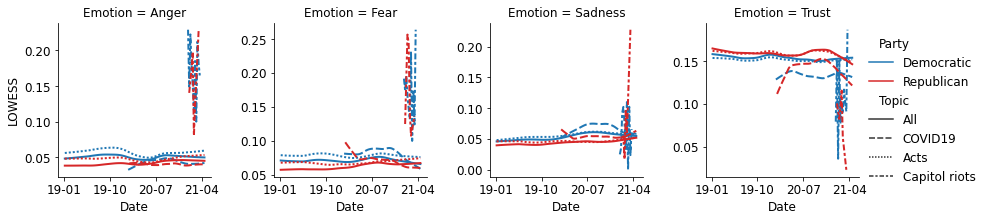

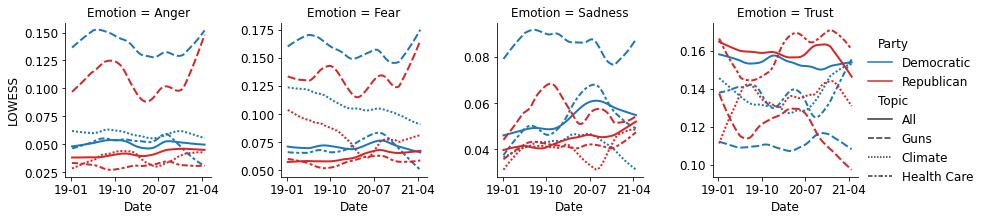

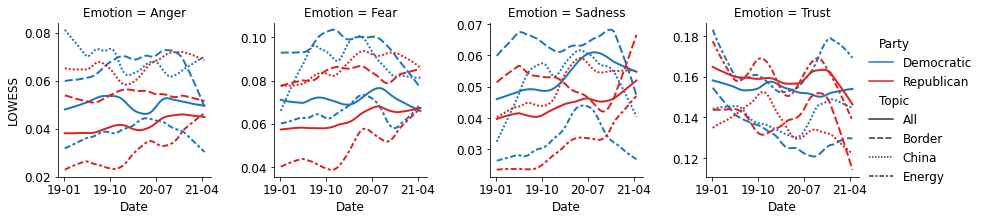

In [29]:
selected_emotions = ['Anger', 'Trust', 'Fear', 'Sadness']
grouped_topics = {
    'General': ['All', 'COVID19', 'Acts', 'Capitol riots'],
    'Democrats': ['All', 'Guns', 'Climate', 'Health Care'],
    'Conservatives': ['All', 'Border', 'China', 'USMCA'],
}

for group, topics in grouped_topics.items():
    g = sns.relplot(
        data=all_topics[all_topics.Topic.isin(topics) & all_topics.Emotion.isin(selected_emotions)],
        x="Date", y='LOWESS', hue="Party", col="Emotion", style='Topic', col_wrap=4,
        kind="line", height=3, palette=party_colors, linewidth = 2,
        facet_kws={'sharey': False, 'sharex': True}
    )

    g.axes[0].set_xticks(g.axes[0].get_xticks()[::3])
    ticks = [datetime.datetime.fromtimestamp(datetime.timedelta(t).total_seconds()).strftime('%y-%m')
             for t in g.axes[0].get_xticks()]
    g.axes[0].set_xticklabels(ticks)

    # plt.savefig(_root_path + f'output/figures/topics/topics_{group}_emotions.png')
    print(group)
    plt.show()

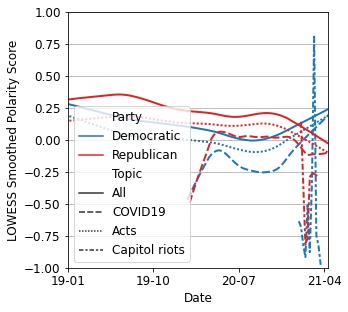

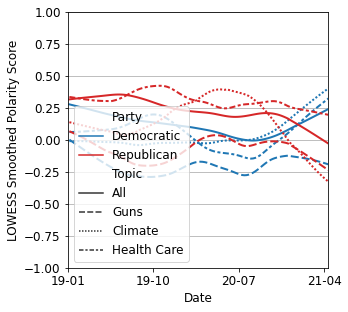

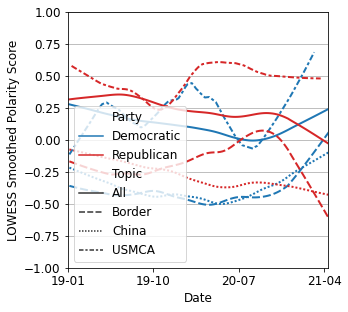

In [9]:
# Polarity per topic
grouped_topics = {
    'General': ['All', 'COVID19', 'Acts', 'Capitol riots'],
    'Democrats': ['All', 'Guns', 'Climate', 'Health Care'],
    'Conservatives': ['All', 'Border', 'China', 'USMCA'],
}

for group, topics in grouped_topics.items():
    data = all_topics[all_topics.Topic.isin(topics) & (all_topics.Emotion == 'Polarity')]
    fig, ax = plt.subplots(figsize=(5,4.5))
    ax.yaxis.grid(True)

    sns.lineplot(data=data, x='Date', y='LOWESS', hue='Party', style='Topic', palette=party_colors, linewidth = 2)
    #sns.lineplot(data=data, x='Date', y='Emotion', hue='Party', style='Topic', palette=party_colors, linewidth = 1, alpha=0.7, legend=False)

    ax.set_xticks(ax.get_xticks()[::3])
    ticks = [datetime.datetime.fromtimestamp(datetime.timedelta(t).total_seconds()).strftime('%y-%m')
             for t in ax.get_xticks()]
    ax.set_xticklabels(ticks)
    plt.xlim([datetime.date(2019,1,1), datetime.date(2021,4,14)])
    plt.ylim((-1,1))
    plt.ylabel('LOWESS Smoothed Polarity Score')
    plt.legend(loc='lower left')
    plt.tight_layout()
    plt.savefig(_root_path + f'output/figures/topics/topics_{group}_polarity.png')
    plt.show()